In [114]:
# Name: Bryan Carty
# Student Id: 19235836
# Email: 19235836@studentmail.ul.ie

# Lab 5: Regression & Dimensionality Reduction

In this notebook, I train a number of regression models to predict the value of the insurance_cost attribute, given a number of predictor attributes. The employed dataset is insurance.csv.

### Imports

In [115]:
import pandas as pd
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import TransformedTargetRegressor

### Exploratory Data Analysis

In [116]:
df = pd.read_csv("./insurance.csv")
df.head()

,age,gender,bmi,children,smoker,region,insurance_cost
0,18,male,33.770,1,no,southeast,1725.55230
1,18,male,34.100,0,no,southeast,1137.01100
2,18,female,26.315,0,no,northeast,2198.18985
3,18,female,38.665,2,no,northeast,3393.35635
4,18,female,35.625,0,no,northeast,2211.13075


In [117]:
df.tail()

,age,gender,bmi,children,smoker,region,insurance_cost
1333,64,female,31.825,2,no,northeast,16069.08475
1334,64,female,26.885,0,yes,northwest,29330.98315
1335,64,male,26.410,0,no,northeast,14394.55790
1336,64,male,36.960,2,yes,southeast,49577.66240
1337,64,male,23.760,0,yes,southeast,26926.51440


Let's examine the `gender`, `smoker`, and `region` attributes first, as they're categorical attributes.

In [118]:
df['gender'].value_counts()


male      676
female    662
Name: gender, dtype: int64

In [119]:
df['gender'].count()

1338

In [120]:
df['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [121]:
df['smoker'].count()

1338

In [122]:
df['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

In [123]:
df['region'].count()

1338

In [124]:
df.isna().sum()

age               0
gender            0
bmi               0
children          0
smoker            0
region            0
insurance_cost    0
dtype: int64

There are no obvious missing values.

Now, I'll analyse the statistics of the numerical attributes.

In [125]:
df.describe()

,age,bmi,children,insurance_cost
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


They all look fine.

Let's check for outliers with boxplots. We will plot `insurance_cost` separately as it has a very large max value.

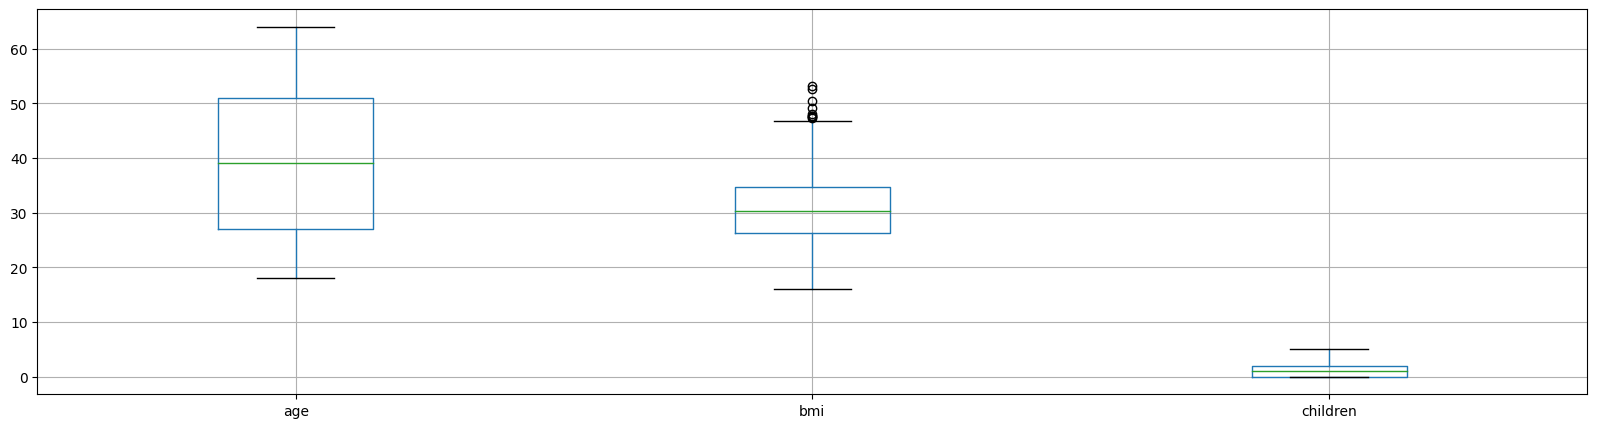

In [126]:
df.drop('insurance_cost', axis=1).boxplot(figsize=(20,5))
plt.show()

`bmi` has a few outliers, but they're not significant, so we will just apply `StandardScaler` to it.

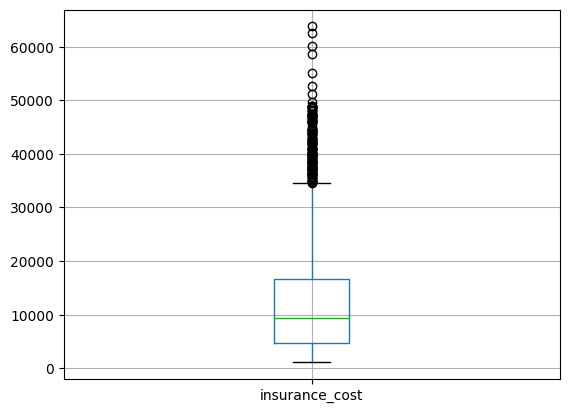

In [127]:
df.boxplot(column=['insurance_cost'])
plt.show()

`insurance_cost` has a lot of outliers. I initially thought that you couldn't scale the target variable as the model would be trained to predict the scaled attribute and not the attribute as it is in the csv file. i.e a scaled `insurance_cost` would be predicted, and not the actual `insurance_cost`. But on further research, I found the sklearn TransformedTargetRegressor class. This class applies a user-specified transformation to the target variable before training the underlying regression model, and then applies the inverse transformation to the predicted target variable to obtain the final predictions. This way we can train the underlying regression model on a transformed target variable and input predictors to improve performance. But during prediction, apply the transformer's inverse transform method to obtain the final predictions in the original scale.

As the `insurance_cost` attribute has a lot of outliers, applied the RobustScaler and log transformation using the TransformedTargetRegressor. But I dound that applying the scale functions resulted in worse result. This would indicate that the above outliers are relevant to accurate prediction.

It's for this reason I've decided to **not** scale the `insurance_cost attribute`

### Data Preparation

First, we replace the categorical columns with multiple numerical columns. These are the `gender`, `smoker`, and `region` columns.

In [128]:
df = pd.get_dummies(df, columns=['gender'], drop_first=True)
df = pd.get_dummies(df, columns=['smoker'], drop_first=True)
df = pd.get_dummies(df, columns=['region'], drop_first=True)

Examine the transformed dataset.

In [129]:
df.head()

,age,bmi,children,insurance_cost,gender_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,18,33.770,1,1725.55230,1,0,0,1,0
1,18,34.100,0,1137.01100,1,0,0,1,0
2,18,26.315,0,2198.18985,0,0,0,0,0
3,18,38.665,2,3393.35635,0,0,0,0,0
4,18,35.625,0,2211.13075,0,0,0,0,0


In [130]:
df.tail()

,age,bmi,children,insurance_cost,gender_male,smoker_yes,region_northwest,region_southeast,region_southwest
1333,64,31.825,2,16069.08475,0,0,0,0,0
1334,64,26.885,0,29330.98315,0,1,1,0,0
1335,64,26.410,0,14394.55790,1,0,0,0,0
1336,64,36.960,2,49577.66240,1,1,0,1,0
1337,64,23.760,0,26926.51440,1,1,0,1,0


Since there are no obvious outliers in the predictor attributes we will apply the standard scaler to them, with the following preprocess pipeline. We will apply the RobustScaler to the target values later using the TransformedTargetRegressor class.

In [131]:
preprocess_pipeline = make_pipeline(StandardScaler())

In [132]:
y = df['insurance_cost']
X = df.drop('insurance_cost', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

### Random Forest Pipeline

In [133]:
# BELOW OUTLINES THE CODE THAT WAS INITIALLY EMPLOYED TO SCALE THE TARGET ATTRIBUTE.
# HOWEVER, THIS WAS FOUND TO RESULT IN LESS ACCURATE PREDICTIONS THAN APPLYING NO SCALING AT ALL.

'''
wrapped_model = TransformedTargetRegressor(regressor=RandomForestRegressor(n_estimators=10), transformer=RobustScaler())
'''

'\nwrapped_model = TransformedTargetRegressor(regressor=RandomForestRegressor(n_estimators=10), transformer=RobustScaler())\n'

In [134]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', RandomForestRegressor(n_estimators=10))])

In [135]:
N_FEATURES_OPTIONS = [2, 6, 11]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.860:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=6), 'reduce_dim__n_features_to_select': 6, 'regresson__max_depth': 4}


c:\Users\bcart\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\bcart\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\bcart\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\bcart\AppData\Local\Programs\Python\Python310\lib\site-packages\skl

### Linear Regression Pipeline

In [136]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', LinearRegression())])

In [137]:
N_FEATURES_OPTIONS = [2, 6, 11]
NORMALIZE_OPTIONS = [False, True]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
LR_best_params = search.best_params_
LR_best_model = search.best_estimator_

c:\Users\bcart\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\bcart\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\bcart\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\bcart\AppData\Local\Programs\Python\Python310\lib\site-packages\skle

Best CV score = 0.747:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=6), 'reduce_dim__n_features_to_select': 6, 'regresson__normalize': False}


c:\Users\bcart\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


The above results would indicate that the RandomForest regression performs better than liner regression. Some possible reasons for this is:
Possible reasons for this are:
- Random Forest Regression works well for non-linear relationships between the independent and dependent variables. Linear Regression assumes a linear relationship between the variables and may not be able to capture the non-linear relationship.
- Random Forest Regression is robust to outliers as it works based on decision trees. Linear Regression can be sensitive to outliers and may not be able to handle them well.

### Compare Regression Models on test set

In [138]:
def evaluate_model(X_test, y_test, model):
    _predicted_values = model.predict(X_test)
    _mse = mean_squared_error(y_test, _predicted_values)
    _mae = mean_absolute_error(y_test, _predicted_values)
    _r2 = r2_score(y_test, _predicted_values)
            
    return _mse, _mae, _r2

We will use the function above to evaluate the best Random Forest and Linear Regression models found by the grid search.

In [139]:
RF_mse, RF_mae, RF_r2 = evaluate_model(X_test, y_test, RF_best_model)
LR_mse, LR_mae, LR_r2 = evaluate_model(X_test, y_test, LR_best_model)

We will use Pandas bar plots to compare results

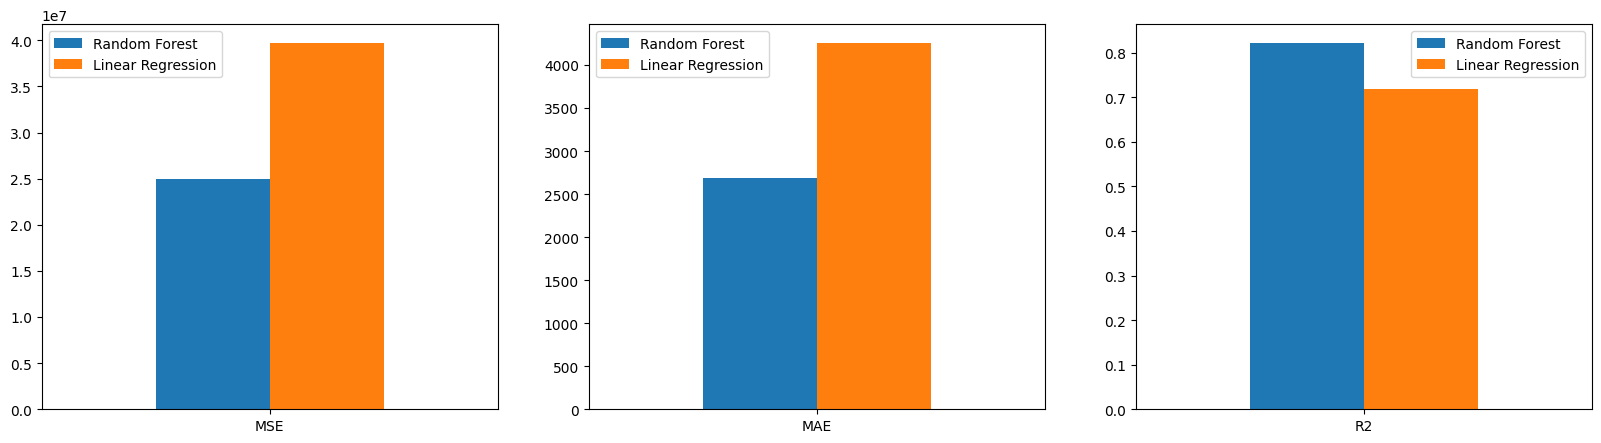

In [140]:
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

Lower MSE and MAE and higher R2 confirms that the Random Forest is the better regression model in this case. 

### Train a final model

In [141]:
def transform(dict, prefix):
    dict_prefix = {key:value for key,value in dict.items() if prefix in key}
    return {key.replace(prefix,''):value for key,value in dict_prefix.items()}

pipe = make_pipeline(preprocess_pipeline, 
                     RF_best_params.get('reduce_dim'),
                     RandomForestRegressor(n_estimators=10, **transform(RF_best_params, 'regresson__')))

final_model =pipe.fit(X, y)

Store this model on disk

In [142]:
filename = 'RF_final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))

### Implement Lasso Regression

In [143]:
from sklearn.linear_model import Lasso
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', Lasso())])

In [144]:
N_FEATURES_OPTIONS = [2, 6, 11]
NORMALIZE_OPTIONS = [False, True]
ALPHA = [1.0, 1.5, 2.0]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__alpha': ALPHA
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__alpha': ALPHA
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
LS_best_params = search.best_params_
LS_best_model = search.best_estimator_

c:\Users\bcart\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\bcart\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\bcart\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\bcart\AppData\Local\Programs\Python\Python310\lib\site-packages\skl

Best CV score = 0.747:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=6), 'reduce_dim__n_features_to_select': 6, 'regresson__alpha': 2.0}


In [145]:
LS_mse, LS_mae, LS_r2 = evaluate_model(X_test, y_test, LS_best_model)

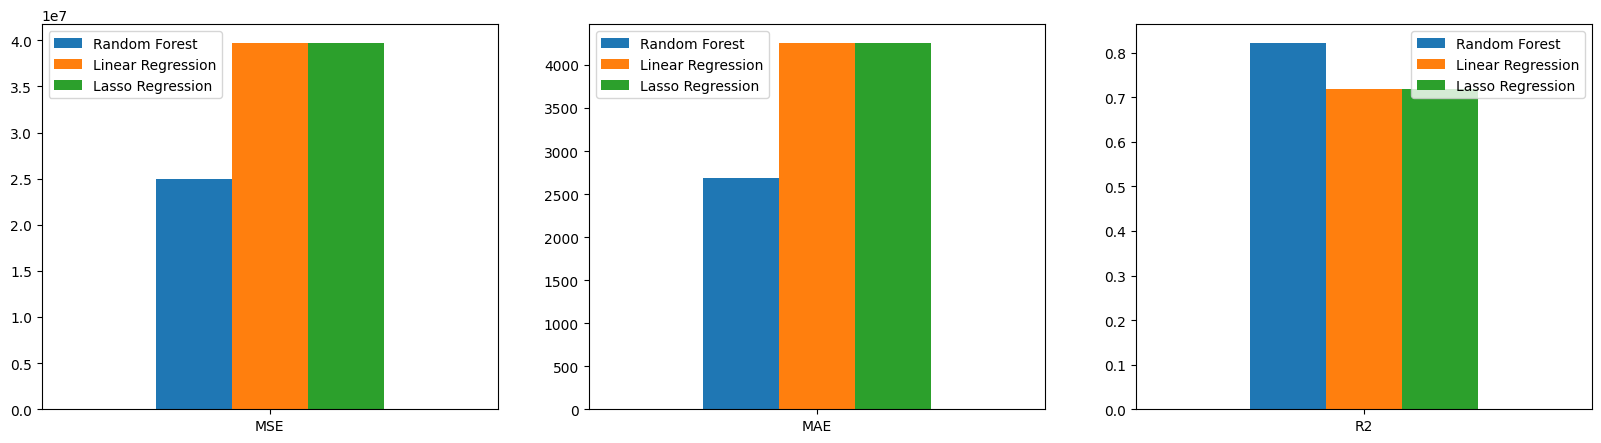

In [146]:
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse, 'Lasso Regression': LS_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae, 'Lasso Regression': LS_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2, 'Lasso Regression': LS_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

Again, Random Forest regression is the most suitable for this particular dataset. It has the lowest MSE, MAE, and the highest R2. Possible situations where Lasso regression could perform worse than Random Forest regression are situations with:

- complex nonlinear relationships.
- a large number of outliers in the data.

In [147]:
def transform(dict, prefix):
    dict_prefix = {key:value for key,value in dict.items() if prefix in key}
    return {key.replace(prefix,''):value for key,value in dict_prefix.items()}

pipe = make_pipeline(preprocess_pipeline, 
                     LS_best_params.get('reduce_dim'),
                     Lasso(**transform(LS_best_params, 'regresson__')))

final_model =pipe.fit(X, y)

Save the Lasso regression model

In [148]:
filename = 'LS_final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))

### Add two dimensionality reduction methods

##### Locally Linear Embedding()

In [149]:
from sklearn.manifold import LocallyLinearEmbedding
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', LocallyLinearEmbedding()),
                       ('regresson', RandomForestRegressor(n_estimators=10))])

final_model =pipe.fit(X, y)

In [150]:
RFLL_mse, RFLL_mae, RFLL_r2 = evaluate_model(X_test, y_test, LS_best_model)

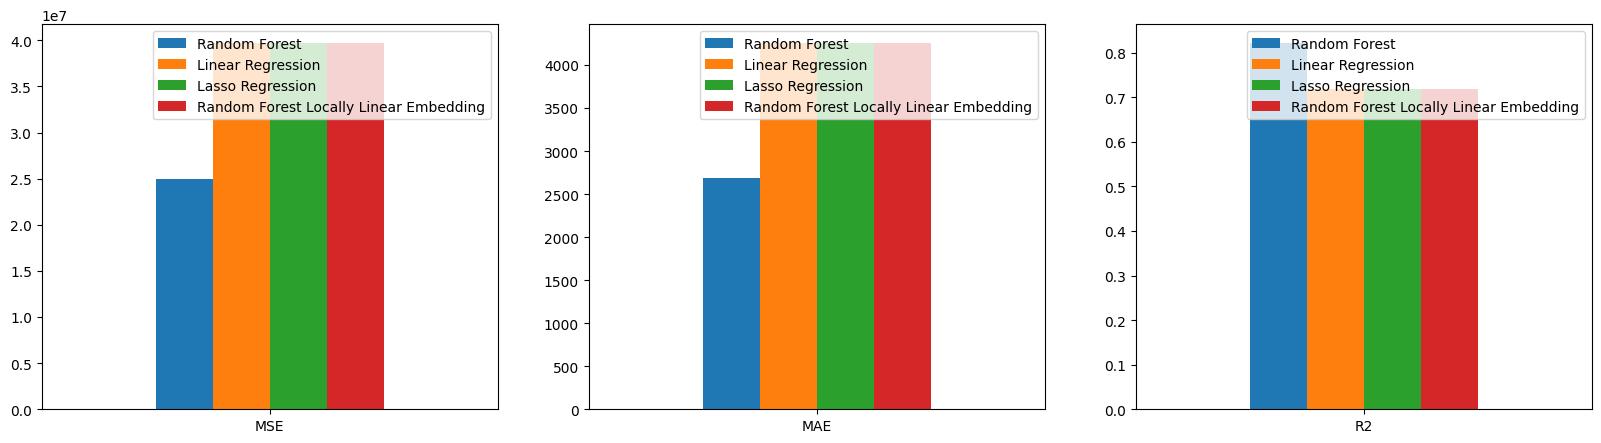

In [151]:
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse, 'Lasso Regression': LS_mse, 'Random Forest Locally Linear Embedding': RFLL_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae, 'Lasso Regression': LS_mae, 'Random Forest Locally Linear Embedding': RFLL_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2, 'Lasso Regression': LS_r2, 'Random Forest Locally Linear Embedding': RFLL_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

The random Forest regression with Locally Linear Embedding performs very similar to the best Linear regression and Lasso regression models. But it doesn't perform as good as the best Random Forest model, which uses RFE for dimensionality reduction. possibly because RFE is primarily a feature selection method that is particularly useful for linear models and reducing the dimensionality of that data, while LLE is a nonlinear dimensionality reduction technique that is particularly useful for preserving the local structure of the data and for nonlinear problems.

##### Isomap()

In [152]:
from sklearn.manifold import Isomap
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', Isomap()),
                       ('regresson', RandomForestRegressor(n_estimators=10))])

final_model =pipe.fit(X, y)

c:\Users\bcart\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_isomap.py:348: UserWarning: The number of connected components of the neighbors graph is 13 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\bcart\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\bcart\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\bcart\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a cs

In [153]:
RFISO_mse, RFISO_mae, RFISO_r2 = evaluate_model(X_test, y_test, LS_best_model)

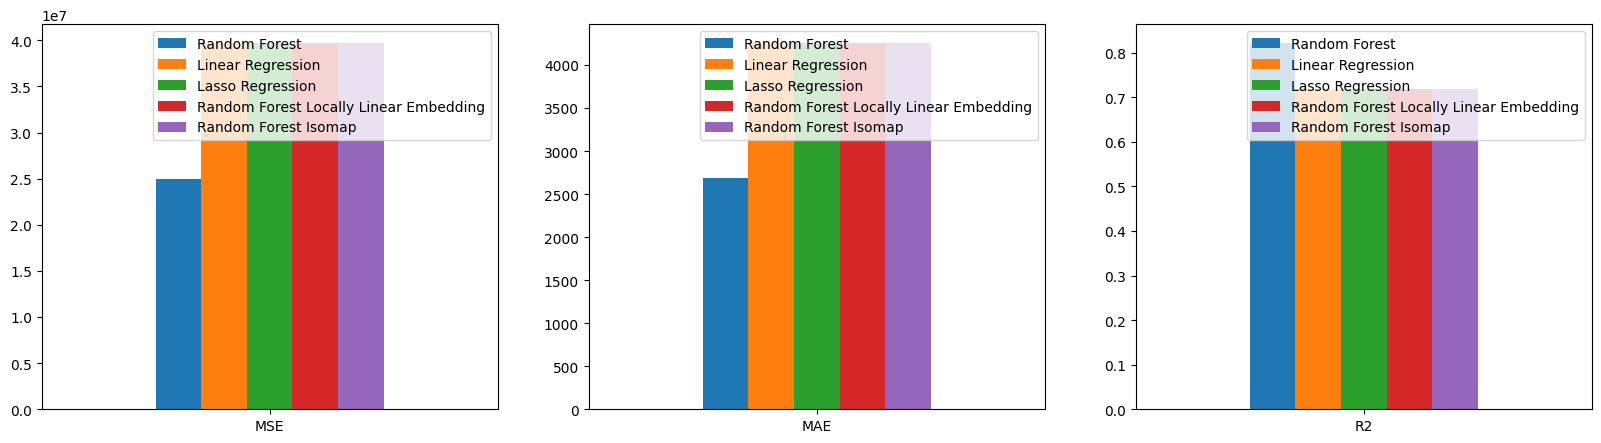

In [154]:
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse, 'Lasso Regression': LS_mse, 'Random Forest Locally Linear Embedding': RFLL_mse, 'Random Forest Isomap': RFISO_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae, 'Lasso Regression': LS_mae, 'Random Forest Locally Linear Embedding': RFLL_mae, 'Random Forest Isomap': RFISO_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2, 'Lasso Regression': LS_r2, 'Random Forest Locally Linear Embedding': RFLL_r2, 'Random Forest Isomap': RFISO_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

Again, we see that Random Forest regression with Isomap dimensionality reduction is very similar to the best linear regression and lasso regression models. it's also very similar to the Random Forest regression with locally linear embedding. A possible reason for this is that Isomap is also a nonlinear dimensionality reduction technique that tries to preserve the global structure of the data.